#### Яргин Захар Hw7

In [2]:
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import scipy.io
device = 'cuda'

#### Загрузка данных

In [3]:
mat = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/hw7/devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('/content/drive/MyDrive/Colab Notebooks/hw7/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [4]:
len(fname_to_class)

8144

In [5]:
len(id_to_car)

196

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
ADD_PATH = '/content/drive/MyDrive/Colab Notebooks/hw7/cars_train'

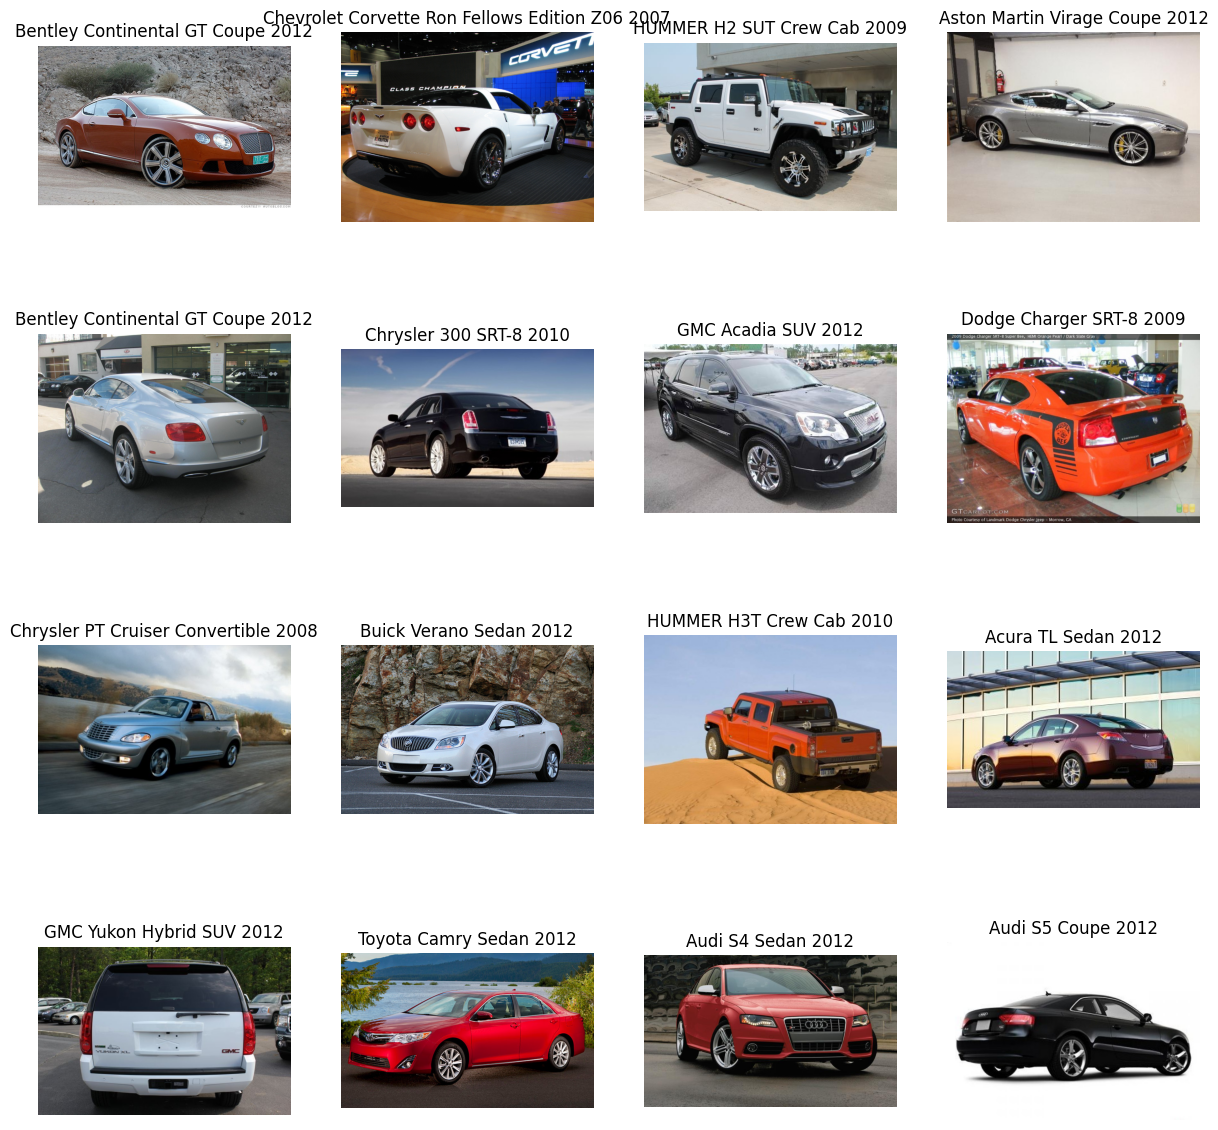

In [8]:
num_imgs = 16
cols = 4
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

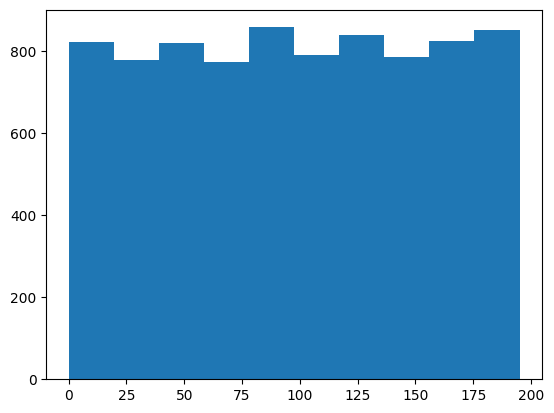

In [9]:
plt.hist(fname_to_class.values())
plt.show()

### Реализуем обертку для данных

In [10]:
import torch
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_transforms =  torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            transforms.RandomApply([transforms.RandomRotation(degrees=(-15, 15))], p=0.3),
            v2.RandomPerspective(distortion_scale=0.15, p=0.3),
            v2.RandomHorizontalFlip(p=0.2),
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

val_transforms =  torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(),
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

In [11]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, train_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Обучим модель

In [13]:
pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 70.5 MB/s eta 0:00:00


In [14]:
#from timm.scheduler import TanhLRScheduler
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
import torch
from torchvision.models import efficientnet_b0
import torch.nn.functional as F
import torch.nn as nn
import random


In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin = 1.0):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        if anchor.dim() == 1:
            anchor = anchor.unsqueeze(0)
            positive = positive.unsqueeze(0)
            negative = negative.unsqueeze(0)

        pos = F.pairwise_distance(anchor, positive)
        neg = F.pairwise_distance(anchor, negative)

        # loss = F.relu(pos**2 - neg**2 + self.margin)
        # return 0.5 * loss.sum()
        loss = F.relu(pos - neg + self.margin)

        return loss.mean()


class CarEmbedder(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size = 512, margin = 1):
        super().__init__()
        self.learning_rate = learning_rate
        self.class_dict = class_dict
        self.margin = margin
        self.emb_size = emb_size

        self.model = efficientnet_b0(pretrained=True)

        self.model.classifier = torch.nn.Sequential(
                            torch.nn.Linear(in_features=1280, out_features=emb_size))

        self.backbone = self.model

        """
        TripletLoss
        """
        self.triplet_loss = TripletLoss(margin = self.margin)

        self.save_hyperparameters()

    def get_triplets(self, embeddings, labels):
        # batch_size = embeddings.shape[0]
        # triplets = []

        # for i in range(batch_size):
        #     anchor_embed = embeddings[i]
        #     anchor_label = labels[i]

        #     pos_indx = [j for j in range(batch_size) if labels[j] == anchor_label and j != i]
        #     neg_indx = [j for j in range(batch_size) if labels[j] != anchor_label]

        #     if len(pos_indx) > 0 and len(neg_indx) > 0:
        #         positive_indx = random.choice(pos_indx)
        #         negative_indx = random.choice(neg_indx)
        #         triplets.append((anchor_embed, embeddings[positive_indx], embeddings[negative_indx]))

        # return triplets
        # batch_size = embeddings.shape[0]
        # labels_expanded = labels.unsqueeze(1)
        # same_class = labels_expanded == labels_expanded.t()

        # triplets = []
        # for i in range(batch_size):

        #     pos_indices = torch.where(same_class[i])[0]
        #     pos_indices = pos_indices[pos_indices != i]
        #     neg_indices = torch.where(~same_class[i])[0]

        #     if len(pos_indices) > 0 and len(neg_indices) > 0:
        #         pos_idx = int(pos_indices[torch.randint(0, len(pos_indices), (1,))].item())
        #         neg_idx = int(neg_indices[torch.randint(0, len(neg_indices), (1,))].item())

        #         anchor = embeddings[i]
        #         positive = embeddings[pos_idx].view(-1)
        #         negative = embeddings[neg_idx].view(-1)

        #         triplets.append((anchor, positive, negative))

        # return triplets

        labels = labels.view(-1)
        N = embeddings.size(0)
        triplets = []
        labels_exp = labels.unsqueeze(1)
        same = (labels_exp == labels_exp.t())
        for i in range(N):
            pos = torch.where(same[i])[0]
            pos = pos[pos != i]
            neg = torch.where(~same[i])[0]
            if pos.numel() == 0 or neg.numel() == 0:
                continue
            p = pos[torch.randint(0, pos.numel(), (1,), device=pos.device)].item()
            n = neg[torch.randint(0, neg.numel(), (1,), device=neg.device)].item()
            triplets.append((embeddings[i], embeddings[p].view(-1), embeddings[n].view(-1)))
        return triplets


    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)

        triplets = self.get_triplets(preds, labels)

        if len(triplets) == 0:
            return None
        else:
            final_loss = torch.stack([self.triplet_loss(a, p, n) for a, p, n in triplets]).mean()

        self.log("train_loss", final_loss,prog_bar=True, logger=True, sync_dist=True)
        return final_loss

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)

        triplets = self.get_triplets(preds, labels)

        if len(triplets) == 0:
            # final_loss = torch.tensor(0.0, requires_grad=True, device=self.device)
            return None
        else:
            final_loss = torch.stack([self.triplet_loss(a, p, n) for a, p, n in triplets]).mean()

        self.log("validation_loss", final_loss,prog_bar=True, logger=True, sync_dist=True)

    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images)
        else:
            preds = self.model(images.unsqueeze(0))
        preds = F.normalize(preds, p=2, dim=1)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [36]:
# model
pl_model = CarEmbedder(id_to_car, 2e-4, 512)
checkpoint_callback = ModelCheckpoint(monitor='validation_loss',mode='min',  save_top_k=3)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=5)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(
    max_epochs=20,
    accelerator=device,
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor])

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False

In [37]:
trainer.fit(model=pl_model, train_dataloaders=train_loader,
            val_dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type         | Params | Mode 
------------------------------------------------------
0 | model        | EfficientNet | 4.7 M  | train
1 | triplet_loss | TripletLoss  | 0      | train
------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.654    Total estimated model params size (MB)
337       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type         | Params | Mode 
------------------------------------------------------
0 | model        | EfficientNet | 4.7 M  | train
1 | triplet_loss | TripletLoss  | 0      | train
------------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.654    Total estimated 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [38]:
trainer.validate(model=pl_model, dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation_loss      │    0.20135271549224854    │
└───────────────────────────┴───────────────────────────┘

[{'validation_loss': 0.20135271549224854}]

In [39]:
import tqdm
import numpy as np
pl_model.eval()
pl_model.to(device)
np.float32

def get_embeds(model, loader):
    embeddings = np.empty((1,512))
    labels = np.empty((1))
    for batch in tqdm.tqdm_notebook(loader):
        imgs = batch['image']
        label = batch['label']
        with torch.no_grad():
            preds = model(imgs.to(device))
        embeddings = np.concatenate([embeddings, preds.cpu().numpy()])
        labels = np.concatenate([labels, label.numpy()])
    return embeddings[1:].astype(np.float32), labels[1:]

train_emb, train_labels = get_embeds(pl_model, train_loader)
val_emb, val_labels = get_embeds(pl_model, valid_loader)

/tmp/ipython-input-1308765255.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm.tqdm_notebook(loader):


  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Форма эмбеддингов: (6464, 512)
Диапазон значений: -0.18974857 0.21169128
Среднее значение: 0.0004529992
Std: 0.04419186
Silhouette score: -0.040589116513729095


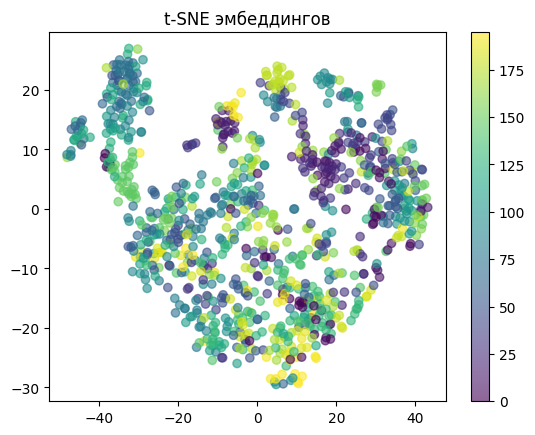

In [40]:
# После получения эмбеддингов проверьте:
print("Форма эмбеддингов:", train_emb.shape)
print("Диапазон значений:", train_emb.min(), train_emb.max())
print("Среднее значение:", train_emb.mean())
print("Std:", train_emb.std())

# Проверьте что эмбеддинги разных классов различаются
from sklearn.metrics import silhouette_score
sil_score = silhouette_score(train_emb, train_labels)
print(f"Silhouette score: {sil_score}")
# > 0.2 - нормально, < 0.1 - плохо

# Визуализируйте эмбеддинги
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(train_emb[:1000])

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=train_labels[:1000], alpha=0.6)
plt.colorbar()
plt.title("t-SNE эмбеддингов")
plt.show()

In [41]:
train_emb.shape

(6464, 512)

In [42]:
!pip install faiss-cpu

In [43]:
import faiss                   # make faiss available
index = faiss.IndexFlatL2(512)   # build the index
print(index.is_trained)
index.add(train_emb)                  # add vectors to the index
print(index.ntotal)

k = 4                          # we want to see 4 nearest neighbors
D, I = index.search(train_emb[:5], k) # sanity check
print(I)
print(D)
D, I = index.search(val_emb, k)     # actual search
print(I[:5])                   # neighbors of the 5 first queries
print(I[-5:])

True
6464
[[   0 6212 1280  573]
 [   1 1877  207 4802]
 [   2 4412 5346 6419]
 [   3 3148  441 2188]
 [   4 5154 3174 3753]]
[[0.         0.19740933 0.25422972 0.25988308]
 [0.         0.3200833  0.32900977 0.3290159 ]
 [0.         0.29385975 0.3553601  0.35649285]
 [0.         0.48202932 0.5417608  0.5480634 ]
 [0.         0.5682214  0.58125246 0.591511  ]]
[[1828 5481 5634 1893]
 [  82 2894  159 3464]
 [1345 2181 3804 1914]
 [2975   88 2815 6257]
 [3722  934 5523 4403]]
[[5915  890  898  385]
 [6412 4384 4697 4028]
 [3734  176 1205  843]
 [5035 1871 5920 1713]
 [3669 3827 2712 6307]]


In [44]:
k_metrics = 4
Distances, Indexes = index.search(val_emb, k_metrics)

In [45]:
def precision_recall(indices, val_labels, train_labels, k):
    precision_sum = 0
    recall_sum = 0

    for i in range(len(val_labels)):
        neighbor_indices = indices[i, :k]
        neighbor_labels = train_labels[neighbor_indices]

        correct = np.sum(neighbor_labels == val_labels[i])
        precision_sum += correct / k

        total_correct_in_train = np.sum(train_labels == val_labels[i])
        recall_sum += correct / total_correct_in_train if total_correct_in_train > 0 else 0

    metrics = {}
    metrics[f'precision@{k}'] = precision_sum / len(val_labels)
    metrics[f'recall@{k}'] = recall_sum / len(val_labels)

    return metrics

In [46]:
precision_recall(Indexes, val_labels, train_labels, k_metrics)

{'precision@4': np.float64(0.3572744014732965),
 'recall@4': np.float64(0.04438169212554303)}

In [47]:
def mapk(Indexes, val_labels, train_labels, k_metrics):
    aps = []

    for i in range(len(val_labels)):
        neighbor_indices = Indexes[i, :k_metrics]
        neighbor_labels = train_labels[neighbor_indices]

        relevant = (neighbor_labels == val_labels[i]).astype(int)

        if np.sum(relevant) > 0:
            # Считаем precision на каждом шаге
            precisions = []
            for j in range(1, k_metrics+1):
                correct_so_far = np.sum(relevant[:j])
                precisions.append(correct_so_far / j)

            relevant_precisions = [precisions[j] for j in range(k_metrics) if relevant[j] == 1]
            ap = np.mean(relevant_precisions)
            aps.append(ap)
        else:
            aps.append(0.0)
    print(f"Map {np.mean(aps)}")
    return np.mean(aps)

In [48]:
mapk(I, val_labels, train_labels, k_metrics)

Map 0.5213832617147534


np.float64(0.5213832617147534)

In [49]:
!pip install grad-cam

In [50]:
from PIL import Image
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(),
                        torchvision.transforms.Resize(
                            size=(224, 224)
                        ),
                        torchvision.transforms.ToTensor()
                        ])

def get_image_from_path(path):
    """A function that gets a path to an image,
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    orig_im = np.array(Image.open(path).convert('RGB'))
    rgb_im = np.array(transform_to_show(orig_im).permute(1,2,0))
    transformed_im = val_transforms(orig_im).unsqueeze(0).to(device)
    orig_im = cv2.resize(orig_im, (512, 512))

    return orig_im, rgb_im, transformed_im

In [51]:
car_img, car_img_float, car_tensor = get_image_from_path("/content/drive/MyDrive/Colab Notebooks/hw7/images/car.png")
cloud_img, cloud_img_float, cloud_tensor = get_image_from_path("/content/drive/MyDrive/Colab Notebooks/hw7/images/cloud.png")
car_concept_features = pl_model(car_tensor)[0, :]
cloud_concept_features = pl_model(cloud_tensor)[0, :]

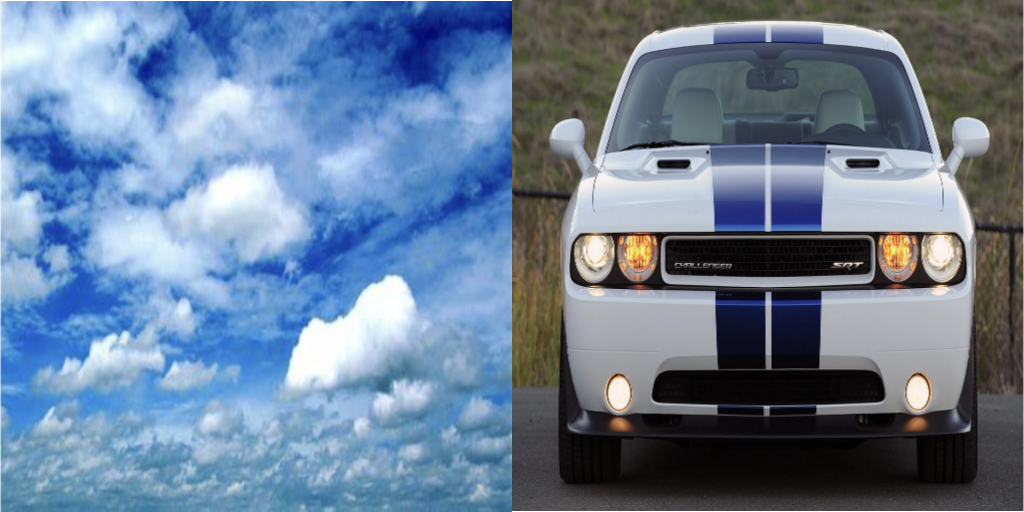

In [52]:
Image.fromarray(np.hstack((cloud_img, car_img)))

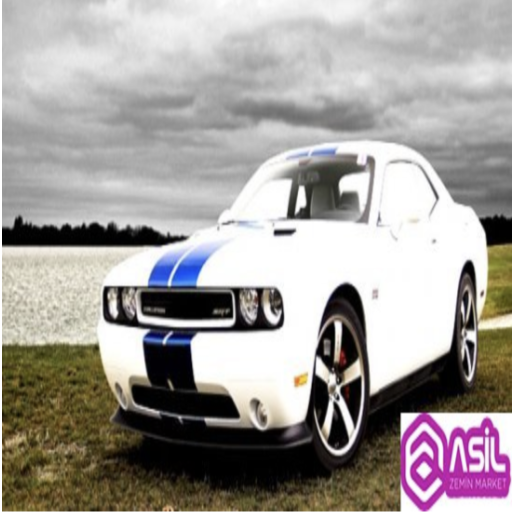

In [53]:
image, image_float, input_tensor = get_image_from_path("/content/drive/MyDrive/Colab Notebooks/hw7/images/car2.png")
Image.fromarray(image)

In [58]:
class SimilarityToConceptTarget:
    def __init__(self, concept_embedding):
        self.concept_embedding = concept_embedding  # [512]

    def __call__(self, model_output):
        # model_output: [1, 1280, 7, 7] - активации из features

        # 1. Делаем global average pooling как в оригинальном EfficientNet
        pooled = model_output.mean([2, 3])  # [1, 1280]

        # 2. Проектируем pooled features в пространство эмбеддингов
        projected = pooled.squeeze()  # [1280]

        # 3. Сравниваем с концептом
        cos_sim = F.cosine_similarity(
            projected.unsqueeze(0),
            self.concept_embedding.unsqueeze(0),
            dim=1
        )

        # 4. ВАЖНО: Умножаем на сумму активаций для правильного градиента
        # Это заставляет CAM фокусироваться на регионах, которые максимизируют схожесть
        return cos_sim * pooled.sum()

target_layers = [pl_model.model.features[-1]]

car_targets = [SimilarityToConceptTarget(car_concept_features)]
cloud_targets = [SimilarityToConceptTarget(cloud_concept_features)]

with GradCAM(model=pl_model.model,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

target_layers = [pl_model.model.features[-1]]

car_targets = [SimilarityToConceptTarget(car_concept_features)]
cloud_targets = [SimilarityToConceptTarget(cloud_concept_features)]

with GradCAM(model=pl_model.model,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

An exception occurred in CAM with block: <class 'IndexError'>. Message: Dimension out of range (expected to be in range of [-1, 0], but got 2)


NameError: name 'car_grayscale_cam' is not defined

In [59]:
class SimilarityToConceptTarget:
    def __init__(self, features, model):
        self.features = features
        self.model = model  # добавляем модель для доступа к classifier

    def __call__(self, model_output):
        # model_output: [1, 1280, 7, 7] - активации из features слоя
        # self.features: [512] - финальные эмбеддинги

        # 1. Делаем global pooling активаций
        pooled = model_output.mean([2, 3])  # [1, 1280]

        # 2. Пропускаем через classifier чтобы получить эмбеддинги
        current_embedding = self.model.classifier(pooled).squeeze(0)  # [512]

        # 3. Теперь сравниваем в одном пространстве
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(current_embedding, self.features)

target_layers = [pl_model.model.features[-1]]

# Передаем модель в target
car_targets = [SimilarityToConceptTarget(car_concept_features, pl_model.model)]
cloud_targets = [SimilarityToConceptTarget(cloud_concept_features, pl_model.model)]

with GradCAM(model=pl_model.model,
             target_layers=target_layers) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

An exception occurred in CAM with block: <class 'IndexError'>. Message: Dimension out of range (expected to be in range of [-1, 0], but got 2)


NameError: name 'car_grayscale_cam' is not defined

In [60]:
with GradCAM(model=pl_model.model,
             target_layers=target_layers) as cam:
    cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=cloud_targets)[0, :]
cloud_cam_image = show_cam_on_image(image_float, cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cloud_cam_image)

An exception occurred in CAM with block: <class 'IndexError'>. Message: Dimension out of range (expected to be in range of [-1, 0], but got 2)


NameError: name 'cloud_grayscale_cam' is not defined